In [1]:
%matplotlib inline
import torch
import kornia as K
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
# data: two patch sets from HPatches https://github.com/hpatches/hpatches-dataset
dir_fname = 'data/hpatches_selected/'
fnames = os.listdir(dir_fname)


Overall procedure idea: rotate patch and meansure inconsistency of the estimated orientation

In [10]:
from kornia.feature import PatchDominantGradientOrientation
from kornia.geometry.transform import center_crop

def normalize_angle(ang):
    '''Map angle to [-Pi, Pi)'''
    #https://stackoverflow.com/a/22949941/1983544
    return ang - (torch.floor((ang + K.pi)/(2.0*K.pi)))*2.0*K.pi;

def benchmark_orientation_consistency(orienter, patches, PS_out, angles=[90., 60., 45., 30.]):
    errors = []
    with torch.no_grad():
        patches_orig_crop = center_crop(patches, (PS_out, PS_out))
        ang_out = normalize_angle(orienter(patches_orig_crop))     
        for ang_gt in angles:
            ang_gt = torch.tensor(ang_gt)
            patches_ang = K.geometry.transform.rotate(patches, ang_gt)
            patches_ang_crop = center_crop(patches_ang, (PS_out, PS_out))
            ang_out_ang = normalize_angle(orienter(patches_ang_crop))
            error_aug = normalize_angle(ang_out + torch.deg2rad(ang_gt) - ang_out_ang).abs()
            errors.append(error_aug.mean())
            print (f'mean consistency error wrt {ang_gt} deg rot = {torch.rad2deg(error_aug.mean()):.1f}') 
    return torch.rad2deg(torch.stack(errors).mean()),  torch.rad2deg(error_aug), ang_out, ang_out_ang

In [11]:
PS = 65
PS_out = 32
ang_bins = 36 #
angles = [90., 60., 45., 30.]
orienter = PatchDominantGradientOrientation(PS_out, 36)
errors = []

for f in fnames[::-1]:
    fname = os.path.join(dir_fname, f)
    print (fname)
    patches = K.image_to_tensor(np.array(Image.open(fname).convert("L"))).float() / 255.
    patches = patches.reshape(-1, 1, PS, PS)
    err, last_error_vector, last_ang_out, last_ang_aug_out = benchmark_orientation_consistency(orienter, patches, PS_out, angles)
    errors.append(err)
print (f'Average error = {torch.stack(errors).mean():.1f} deg')

data/hpatches_selected/i_porta_e1.png
mean consistency error wrt 90.0 deg rot = 0.0
mean consistency error wrt 60.0 deg rot = 1.7
mean consistency error wrt 45.0 deg rot = 2.0
mean consistency error wrt 30.0 deg rot = 1.9
data/hpatches_selected/v_graffiti_h4.png
mean consistency error wrt 90.0 deg rot = 0.0
mean consistency error wrt 60.0 deg rot = 0.6
mean consistency error wrt 45.0 deg rot = 1.0
mean consistency error wrt 30.0 deg rot = 0.6
data/hpatches_selected/v_graffiti_e1.png
mean consistency error wrt 90.0 deg rot = 0.0
mean consistency error wrt 60.0 deg rot = 0.8
mean consistency error wrt 45.0 deg rot = 1.0
mean consistency error wrt 30.0 deg rot = 0.7
data/hpatches_selected/i_porta_h4.png
mean consistency error wrt 90.0 deg rot = 0.2
mean consistency error wrt 60.0 deg rot = 1.9
mean consistency error wrt 45.0 deg rot = 2.4
mean consistency error wrt 30.0 deg rot = 1.5
Average error = 1.0 deg


In [4]:
last_error_vector.shape

torch.Size([1123])

Original patch, rotated by estimated ori, rotated by estimated ori after 30.0 rot
0.2, error [deg]
Original patch, rotated by estimated ori, rotated by estimated ori after 30.0 rot
0.1, error [deg]
Original patch, rotated by estimated ori, rotated by estimated ori after 30.0 rot
0.5, error [deg]


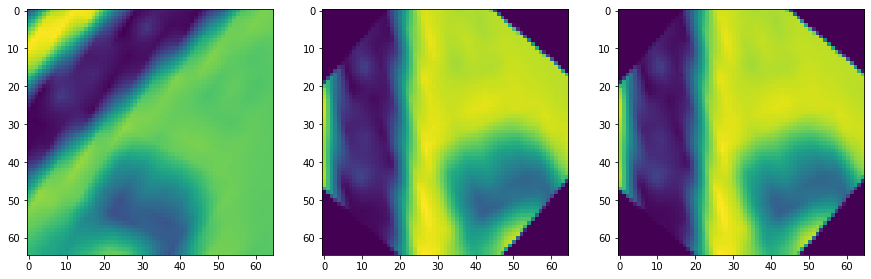

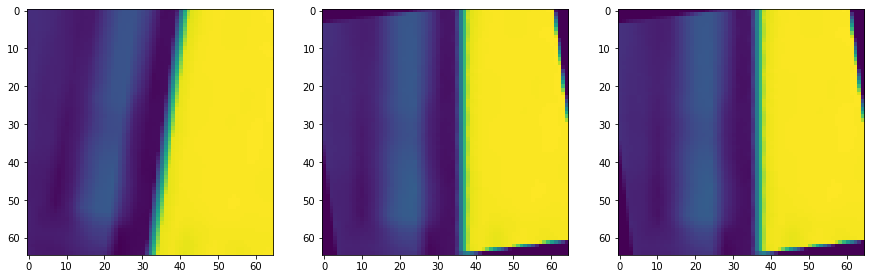

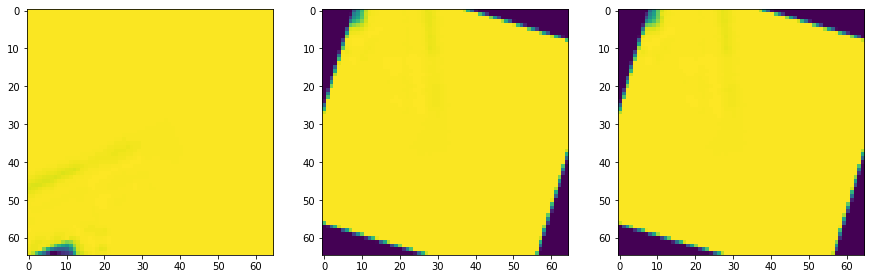

In [13]:
# Visual sanity check
def imshow_torch_channels(tensor, dim = 1, *kwargs):
    num_ch = tensor.size(dim)
    fig=plt.figure(figsize=(num_ch*5,5))
    tensor_splitted = torch.split(tensor, 1, dim=dim)
    for i in range(num_ch):
        fig.add_subplot(1, num_ch, i+1)
        plt.imshow(K.tensor_to_image(tensor_splitted[i].squeeze(dim)), *kwargs)
    return


ang_gt = torch.tensor(angles[-1])
for idx in [10,20,30]:
    print (f"Original patch, rotated by estimated ori, rotated by estimated ori after {ang_gt.item()} rot")
    print (f"{last_error_vector[idx].item():.1f}, error [deg]")
    out = torch.cat([
        patches[idx:idx+1],
        K.geometry.transform.rotate(patches[idx:idx+1], torch.rad2deg(-last_ang_out[idx:idx+1])),
        K.geometry.transform.rotate(patches[idx:idx+1], torch.rad2deg(-last_ang_aug_out[idx:idx+1])+ang_gt)], dim=0)
    imshow_torch_channels(out,0)


Comparision to OriNet from AffNet paper

In [15]:
!wget https://github.com/ducha-aiki/affnet/raw/master/convertJIT/OriNetJIT.pt

--2023-04-03 16:32:29--  https://github.com/ducha-aiki/affnet/raw/master/convertJIT/OriNetJIT.pt
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ducha-aiki/affnet/master/convertJIT/OriNetJIT.pt [following]
--2023-04-03 16:32:29--  https://raw.githubusercontent.com/ducha-aiki/affnet/master/convertJIT/OriNetJIT.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 350550 (342K) [application/octet-stream]
Saving to: ‘OriNetJIT.pt’

OriNetJIT.pt        100%[===================>] 342,33K  --.-KB/s    in 0,06s   

2023-04-03 16:32:29 (5,61 MB/s) - ‘OriNetJIT.pt’ saved [350550/350550]



In [16]:
OriNet = torch.jit.load('OriNetJIT.pt')
def orinet_radians(inp):
    yx = OriNet(inp)
    return torch.atan2(yx[:,0],yx[:,1])

PS = 65
PS_out = 32
ang_bins = 36 #
angles = [90., 60., 45., 30.]
orienter = orinet_radians
errors = []

for f in fnames[::-1]:
    fname = os.path.join(dir_fname, f)
    print (fname)
    patches = K.image_to_tensor(np.array(Image.open(fname).convert("L"))).float() / 255.
    patches = patches.reshape(-1, 1, PS, PS)
    err, last_error_vector, last_ang_out, last_ang_aug_out = benchmark_orientation_consistency(orienter, patches, PS_out, angles)
    errors.append(err)
print (f'Average error = {torch.stack(errors).mean():.1f} deg')

data/hpatches_selected/i_porta_e1.png
mean consistency error wrt 90.0 deg rot = 3.3
mean consistency error wrt 60.0 deg rot = 3.3
mean consistency error wrt 45.0 deg rot = 3.1
mean consistency error wrt 30.0 deg rot = 2.9
data/hpatches_selected/v_graffiti_h4.png
mean consistency error wrt 90.0 deg rot = 2.5
mean consistency error wrt 60.0 deg rot = 2.8
mean consistency error wrt 45.0 deg rot = 2.7
mean consistency error wrt 30.0 deg rot = 2.5
data/hpatches_selected/v_graffiti_e1.png
mean consistency error wrt 90.0 deg rot = 2.8
mean consistency error wrt 60.0 deg rot = 3.1
mean consistency error wrt 45.0 deg rot = 2.9
mean consistency error wrt 30.0 deg rot = 2.7
data/hpatches_selected/i_porta_h4.png
mean consistency error wrt 90.0 deg rot = 3.0
mean consistency error wrt 60.0 deg rot = 3.2
mean consistency error wrt 45.0 deg rot = 3.1
mean consistency error wrt 30.0 deg rot = 2.9
Average error = 2.9 deg


Original patch, rotated by estimated ori, rotated by estimated ori after 30.0 rot
4.3, error [deg]
Original patch, rotated by estimated ori, rotated by estimated ori after 30.0 rot
0.1, error [deg]
Original patch, rotated by estimated ori, rotated by estimated ori after 30.0 rot
1.8, error [deg]


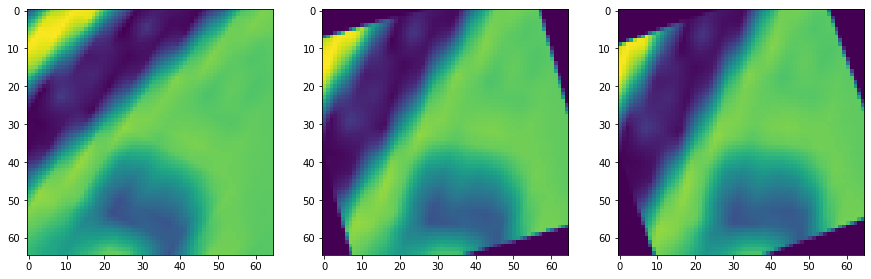

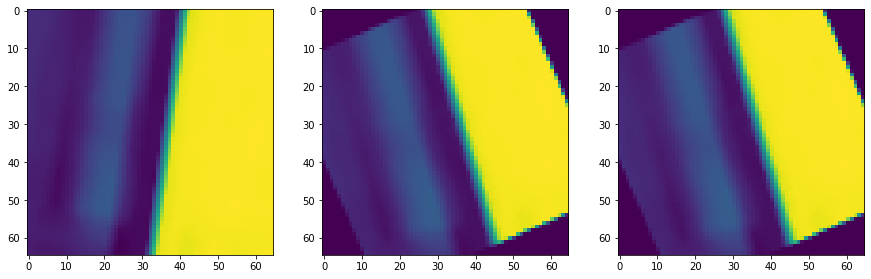

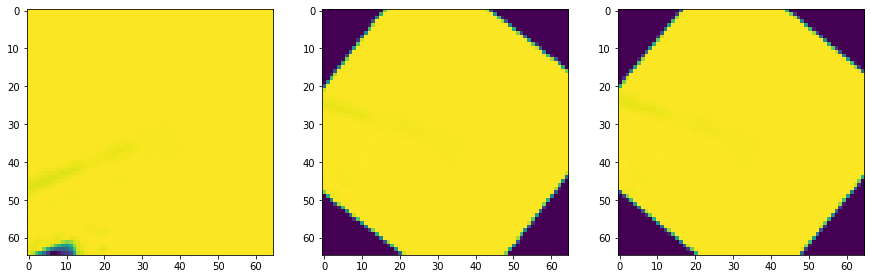

In [17]:
# Visual sanity check
def imshow_torch_channels(tensor, dim = 1, *kwargs):
    num_ch = tensor.size(dim)
    fig=plt.figure(figsize=(num_ch*5,5))
    tensor_splitted = torch.split(tensor, 1, dim=dim)
    for i in range(num_ch):
        fig.add_subplot(1, num_ch, i+1)
        plt.imshow(K.tensor_to_image(tensor_splitted[i].squeeze(dim)), *kwargs)
    return


ang_gt = torch.tensor(angles[-1])
for idx in [10,20,30]:
    print (f"Original patch, rotated by estimated ori, rotated by estimated ori after {ang_gt.item()} rot")
    print (f"{last_error_vector[idx].item():.1f}, error [deg]")
    out = torch.cat([
        patches[idx:idx+1],
        K.geometry.transform.rotate(patches[idx:idx+1], torch.rad2deg(-last_ang_out[idx:idx+1])),
        K.geometry.transform.rotate(patches[idx:idx+1], torch.rad2deg(-last_ang_aug_out[idx:idx+1])+ang_gt)], dim=0)
    imshow_torch_channels(out,0)
